## Paddy Disease Classification

**meta_train.csv** - The training set

- `image_id` - Unique image identifier corresponds to image file names (.jpg) found in the train_images directory.
- `label` - Type of paddy disease, also the target class. There are ten categories, including the normal leaf.
- `variety` - The name of the paddy variety.
- `age` - Age of the paddy in days.

**train_images** - This directory contains 10,407 training images stored under different sub-directories corresponding to ten target classes. Filename corresponds to the `image_id` column of `meta_train.csv`.

**test_images** - This directory contains 3,469 test set images.

In [1]:
import os, sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
from PIL import Image
from pathlib import Path
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras import Model, models

# Reproducible results
np.random.seed(42)
tf.random.set_seed(42)

# Misc.
plt.style.use('ggplot')
model_name = 'clf-cnn'
dir_train_dataset = 'data/train/'
dir_test_dataset = 'data/test/'
dir_log = 'log/' + model_name
dir_models = 'models/'
path_model = dir_models + model_name


# Environment information
print("TF version:", tf.__version__)
print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "NOT AVAILABLE")

TF version: 2.18.0
GPU is available


In [2]:
tf.keras.backend.clear_session()

In [5]:
def load(from_dir: str) -> pd.DataFrame:
    """
    Load a directory of paddy leaf disease images (e.g., data/train or data/test) into a DataFrame.

    Each subfolder is assumed to be a disease class label.

    Returns a DataFrame with:
    - image_path: Relative to from_dir
    - file_type: Extension
    - width, height: Image dimensions
    - ratio: width / height
    - mode: Image mode (e.g. RGB)
    - bands: Space-separated bands (e.g. "R G B")
    - transparency: Whether the image has an alpha channel
    - animated: Whether the image is an animated image (like GIF)
    - label: The disease class (from the folder name)
    """

    from_dir = Path(from_dir)
    data = {
        'image_path': [],
        'file_type': [],
        'width': [],
        'height': [],
        'ratio': [],
        'mode': [],
        'bands': [],
        'transparency': [],
        'animated': [],
        'label': []
    }

    for label_dir in from_dir.iterdir():
        if not label_dir.is_dir():
            continue

        for img_file in label_dir.iterdir():
            try:
                with Image.open(img_file) as im:
                    data['image_path'].append(str(img_file.relative_to(from_dir)))
                    data['file_type'].append(img_file.suffix.lstrip('.').lower())
                    data['width'].append(im.width)
                    data['height'].append(im.height)
                    data['ratio'].append(im.width / im.height)
                    data['mode'].append(im.mode)
                    data['bands'].append(' '.join(im.getbands()))
                    data['transparency'].append(
                        im.mode in ('RGBA', 'RGBa', 'LA', 'La', 'PA') or
                        (im.mode == 'P' and 'transparency' in im.info)
                    )
                    data['animated'].append(getattr(im, 'is_animated', False))
                    data['label'].append(label_dir.name)
            except Exception as e:
                print(f"Failed to process {img_file}: {e}")

    return pd.DataFrame(data)

In [6]:
df_train = load(dir_train_dataset)

In [7]:
df_train.head()

image_path file_type  width  height  ratio  \
0  bacterial_panicle_blight/108878_676a3a.jpg       jpg    256     256    1.0   
1  bacterial_panicle_blight/105118_eeec16.jpg       jpg    256     256    1.0   
2  bacterial_panicle_blight/105875_019f8e.jpg       jpg    256     256    1.0   
3  bacterial_panicle_blight/104678_62d0eb.jpg       jpg    256     256    1.0   
4  bacterial_panicle_blight/103733_126b28.jpg       jpg    256     256    1.0   

  mode  bands  transparency  animated                     label  
0  RGB  R G B         False     False  bacterial_panicle_blight  
1  RGB  R G B         False     False  bacterial_panicle_blight  
2  RGB  R G B         False     False  bacterial_panicle_blight  
3  RGB  R G B         False     False  bacterial_panicle_blight  
4  RGB  R G B         False     False  bacterial_panicle_blight

In [8]:
df_train.describe()

width   height    ratio
count  14112.0  14112.0  14112.0
mean     256.0    256.0      1.0
std        0.0      0.0      0.0
min      256.0    256.0      1.0
25%      256.0    256.0      1.0
50%      256.0    256.0      1.0
75%      256.0    256.0      1.0
max      256.0    256.0      1.0

In [9]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14112 entries, 0 to 14111
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   image_path    14112 non-null  object 
 1   file_type     14112 non-null  object 
 2   width         14112 non-null  int64  
 3   height        14112 non-null  int64  
 4   ratio         14112 non-null  float64
 5   mode          14112 non-null  object 
 6   bands         14112 non-null  object 
 7   transparency  14112 non-null  bool   
 8   animated      14112 non-null  bool   
 9   label         14112 non-null  object 
dtypes: bool(2), float64(1), int64(2), object(5)
memory usage: 909.7+ KB


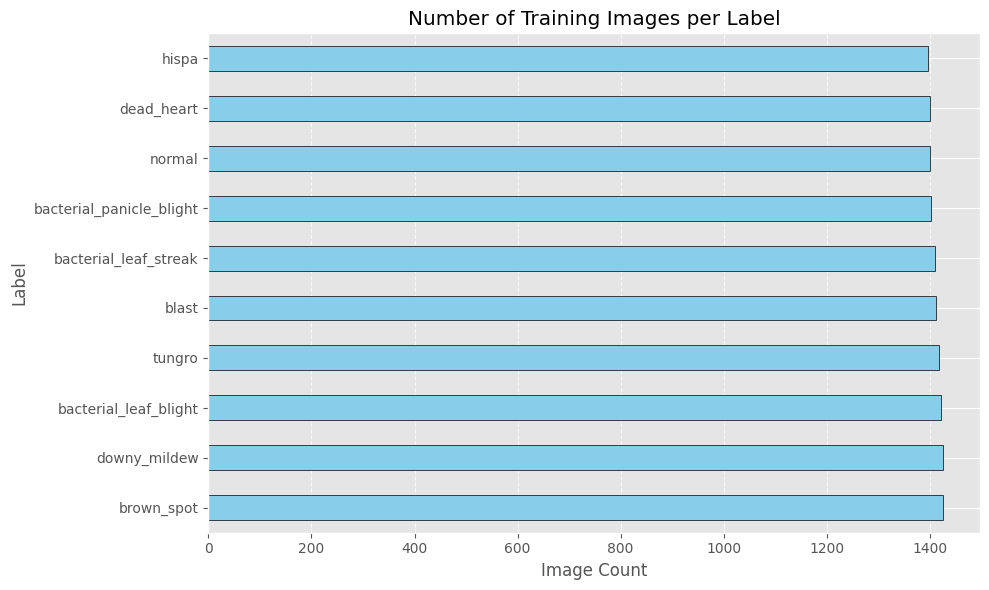

In [10]:
label_counts = df_train['label'].value_counts()

plt.figure(figsize=(10, 6))
label_counts.plot(kind='barh', color='skyblue', edgecolor='black')

plt.title('Number of Training Images per Label')
plt.xlabel('Image Count')
plt.ylabel('Label')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [11]:
train, val = train_test_split(df_train, shuffle=True, test_size=0.2, random_state=42)  # 80/20/20 - train/val/test

print(f'Train data: {train.shape[0]} samples, Validation Data: {val.shape[0]} samples.')

Train data: 11289 samples, Validation Data: 2823 samples.


In [12]:
TARGET_IMG_SIZE = 256

In [13]:
# Model Parameters
BATCH_SIZE = 32
OUTPUT_CLASSES = 10  # One-hot encoded: 10 different classes

# Training Parameters
EPOCHS = 20
LEARNING_RATE = 0.0001
MOMENTUM = 0.9

In [14]:
model = tf.keras.Sequential([
    # Block 1
    tf.keras.Input(shape=(256, 256, 3)),
    tf.keras.layers.Rescaling(1./255),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2, 2)),

    # Block 2
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2, 2)),

    # Block 3
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2, 2)),

    # Block 4
    tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2, 2)),

    # Block 5
    tf.keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.GlobalMaxPooling2D(),

    # Dense Layers
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(OUTPUT_CLASSES, activation='softmax')
], name=model_name)

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
    metrics=['categorical_accuracy']
)

In [15]:
model.summary()

Model: "clf-cnn"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 256, 256, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 256, 256, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 256, 256, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 256, 256, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 128, 128, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 128, 128, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 128, 128, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 128, 128, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 64, 64, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 64, 64, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 64, 64, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 32, 32, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 32, 32, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 32, 32, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 16, 16, 256)    │             

 Total params: 5,116,714 (19.52 MB)

 Trainable params: 5,112,746 (19.50 MB)

 Non-trainable params: 3,968 (15.50 KB)

In [16]:
train['label'] = train['label'].astype('str')
train_datagen = ImageDataGenerator(
    data_format='channels_last'
)
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train,
    directory=dir_train_dataset,
    x_col='image_path',
    y_col='label',
    target_size=(TARGET_IMG_SIZE, TARGET_IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    seed=42
)

val['label'] = val['label'].astype('str')
val_datagen = ImageDataGenerator(data_format='channels_last')
val_generator = val_datagen.flow_from_dataframe(
    dataframe=val,
    directory=dir_train_dataset,
    x_col='image_path',
    y_col='label',
    target_size=(TARGET_IMG_SIZE, TARGET_IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    seed=42
)

Found 11289 validated image filenames belonging to 10 classes.
Found 2823 validated image filenames belonging to 10 classes.


In [17]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=dir_log, write_graph=False)
history = model.fit(
    train_generator, validation_data=val_generator,
    epochs=EPOCHS, verbose=1,
    callbacks=[tensorboard_callback]
)

Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


353/353 ━━━━━━━━━━━━━━━━━━━━ 159s 355ms/step - categorical_accuracy: 0.1601 - loss: 3.5547 - val_categorical_accuracy: 0.0921 - val_loss: 2.8259
Epoch 2/20
353/353 ━━━━━━━━━━━━━━━━━━━━ 88s 248ms/step - categorical_accuracy: 0.3212 - loss: 1.9119 - val_categorical_accuracy: 0.5384 - val_loss: 1.4947
Epoch 3/20
353/353 ━━━━━━━━━━━━━━━━━━━━ 89s 251ms/step - categorical_accuracy: 0.4742 - loss: 1.5339 - val_categorical_accuracy: 0.6706 - val_loss: 1.0857
Epoch 4/20
353/353 ━━━━━━━━━━━━━━━━━━━━ 142s 251ms/step - categorical_accuracy: 0.5850 - loss: 1.2432 - val_categorical_accuracy: 0.6961 - val_loss: 0.9547
Epoch 5/20
353/353 ━━━━━━━━━━━━━━━━━━━━ 88s 250ms/step - categorical_accuracy: 0.6925 - loss: 0.9393 - val_categorical_accuracy: 0.8193 - val_loss: 0.6187
Epoch 6/20
353/353 ━━━━━━━━━━━━━━━━━━━━ 88s 249ms/step - categorical_accuracy: 0.7697 - loss: 0.7090 - val_categorical_accuracy: 0.8247 - val_loss: 0.5512
Epoch 7/20
353/353 ━━━━━━━━━━━━━━━━━━━━ 88s 249ms/step - categorical_accuracy: 

In [18]:
def plot_learning_curve(
        train_loss, val_loss, train_metric, val_metric,
        to_file: str = None
) -> None:
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))

    ax[0].plot(train_loss, 'r--')
    ax[0].plot(val_loss, 'b--')
    ax[0].set_xlabel("epochs")
    ax[0].set_ylabel("Loss")
    ax[0].legend(['train', 'val'])

    ax[1].plot(train_metric, 'r--')
    ax[1].plot(val_metric, 'b--')
    ax[1].set_xlabel('epochs')
    ax[1].set_ylabel('Accuracy')
    ax[1].axhline(y=0.125, c='g', alpha=0.5)  # Random probability - naive classifier
    ax[1].legend(['train', 'val', 'random baseline'])

    fig.tight_layout()
    plt.show()
    if to_file is not None:
        fig.savefig(to_file)

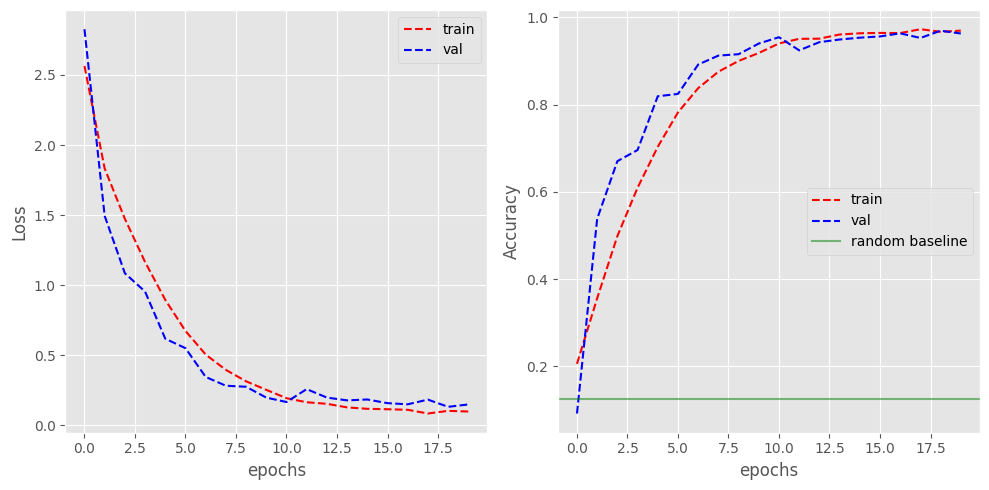

In [20]:
plot_learning_curve(
    history.history['loss'],
    history.history['val_loss'],
    history.history['categorical_accuracy'],
    history.history['val_categorical_accuracy'],
)

In [21]:
test = load(dir_test_dataset)
test['label'] = test['label'].astype('str')
test_datagen = ImageDataGenerator(data_format='channels_last')
test_generator = test_datagen.flow_from_dataframe(
    dataframe=test,
    directory=dir_test_dataset,
    x_col='image_path',
    y_col='label',
    target_size=(TARGET_IMG_SIZE, TARGET_IMG_SIZE),
    batch_size=1,
    class_mode='categorical',
    seed=42,
    shuffle=False
)

Found 2844 validated image filenames belonging to 10 classes.


In [22]:
def visualize_32predictions(
    model: Model,
    test_generator,
    to_file: str = None
) -> None:
    fig, ax = plt.subplots(8, 4, figsize=(20, 20))
    ax = ax.ravel()

    class_labels = list(test_generator.class_indices.keys())
    sample_indices = random.sample(range(len(test_generator.filenames)), 32)

    for i, idx in enumerate(sample_indices):
        img_path = test_generator.filepaths[idx]

        # Load the image manually
        img = image.load_img(img_path, target_size=test_generator.target_size)
        img_array = image.img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)

        # Predict
        pred = model.predict(img_array, verbose=0)

        predicted_index = np.argmax(pred)
        predicted_label = class_labels[predicted_index]

        true_index = test_generator.classes[idx]
        true_label = class_labels[true_index]

        ax[i].imshow(img)
        ax[i].axis('off')
        ax[i].set_title(
            f'Ground Truth: {true_label}\nPrediction: {predicted_label}',
            fontsize=8
        )
        ax[i].text(
            0.5, 1.15, f'{"CORRECT" if predicted_index == true_index else "INCORRECT"}',
            horizontalalignment='center',
            verticalalignment='bottom',
            transform=ax[i].transAxes,
            fontsize=8,
            color='green' if predicted_index == true_index else 'red',
            weight='bold'
        )

    plt.tight_layout()
    plt.show()

    if to_file:
        fig.savefig(to_file, bbox_inches='tight')

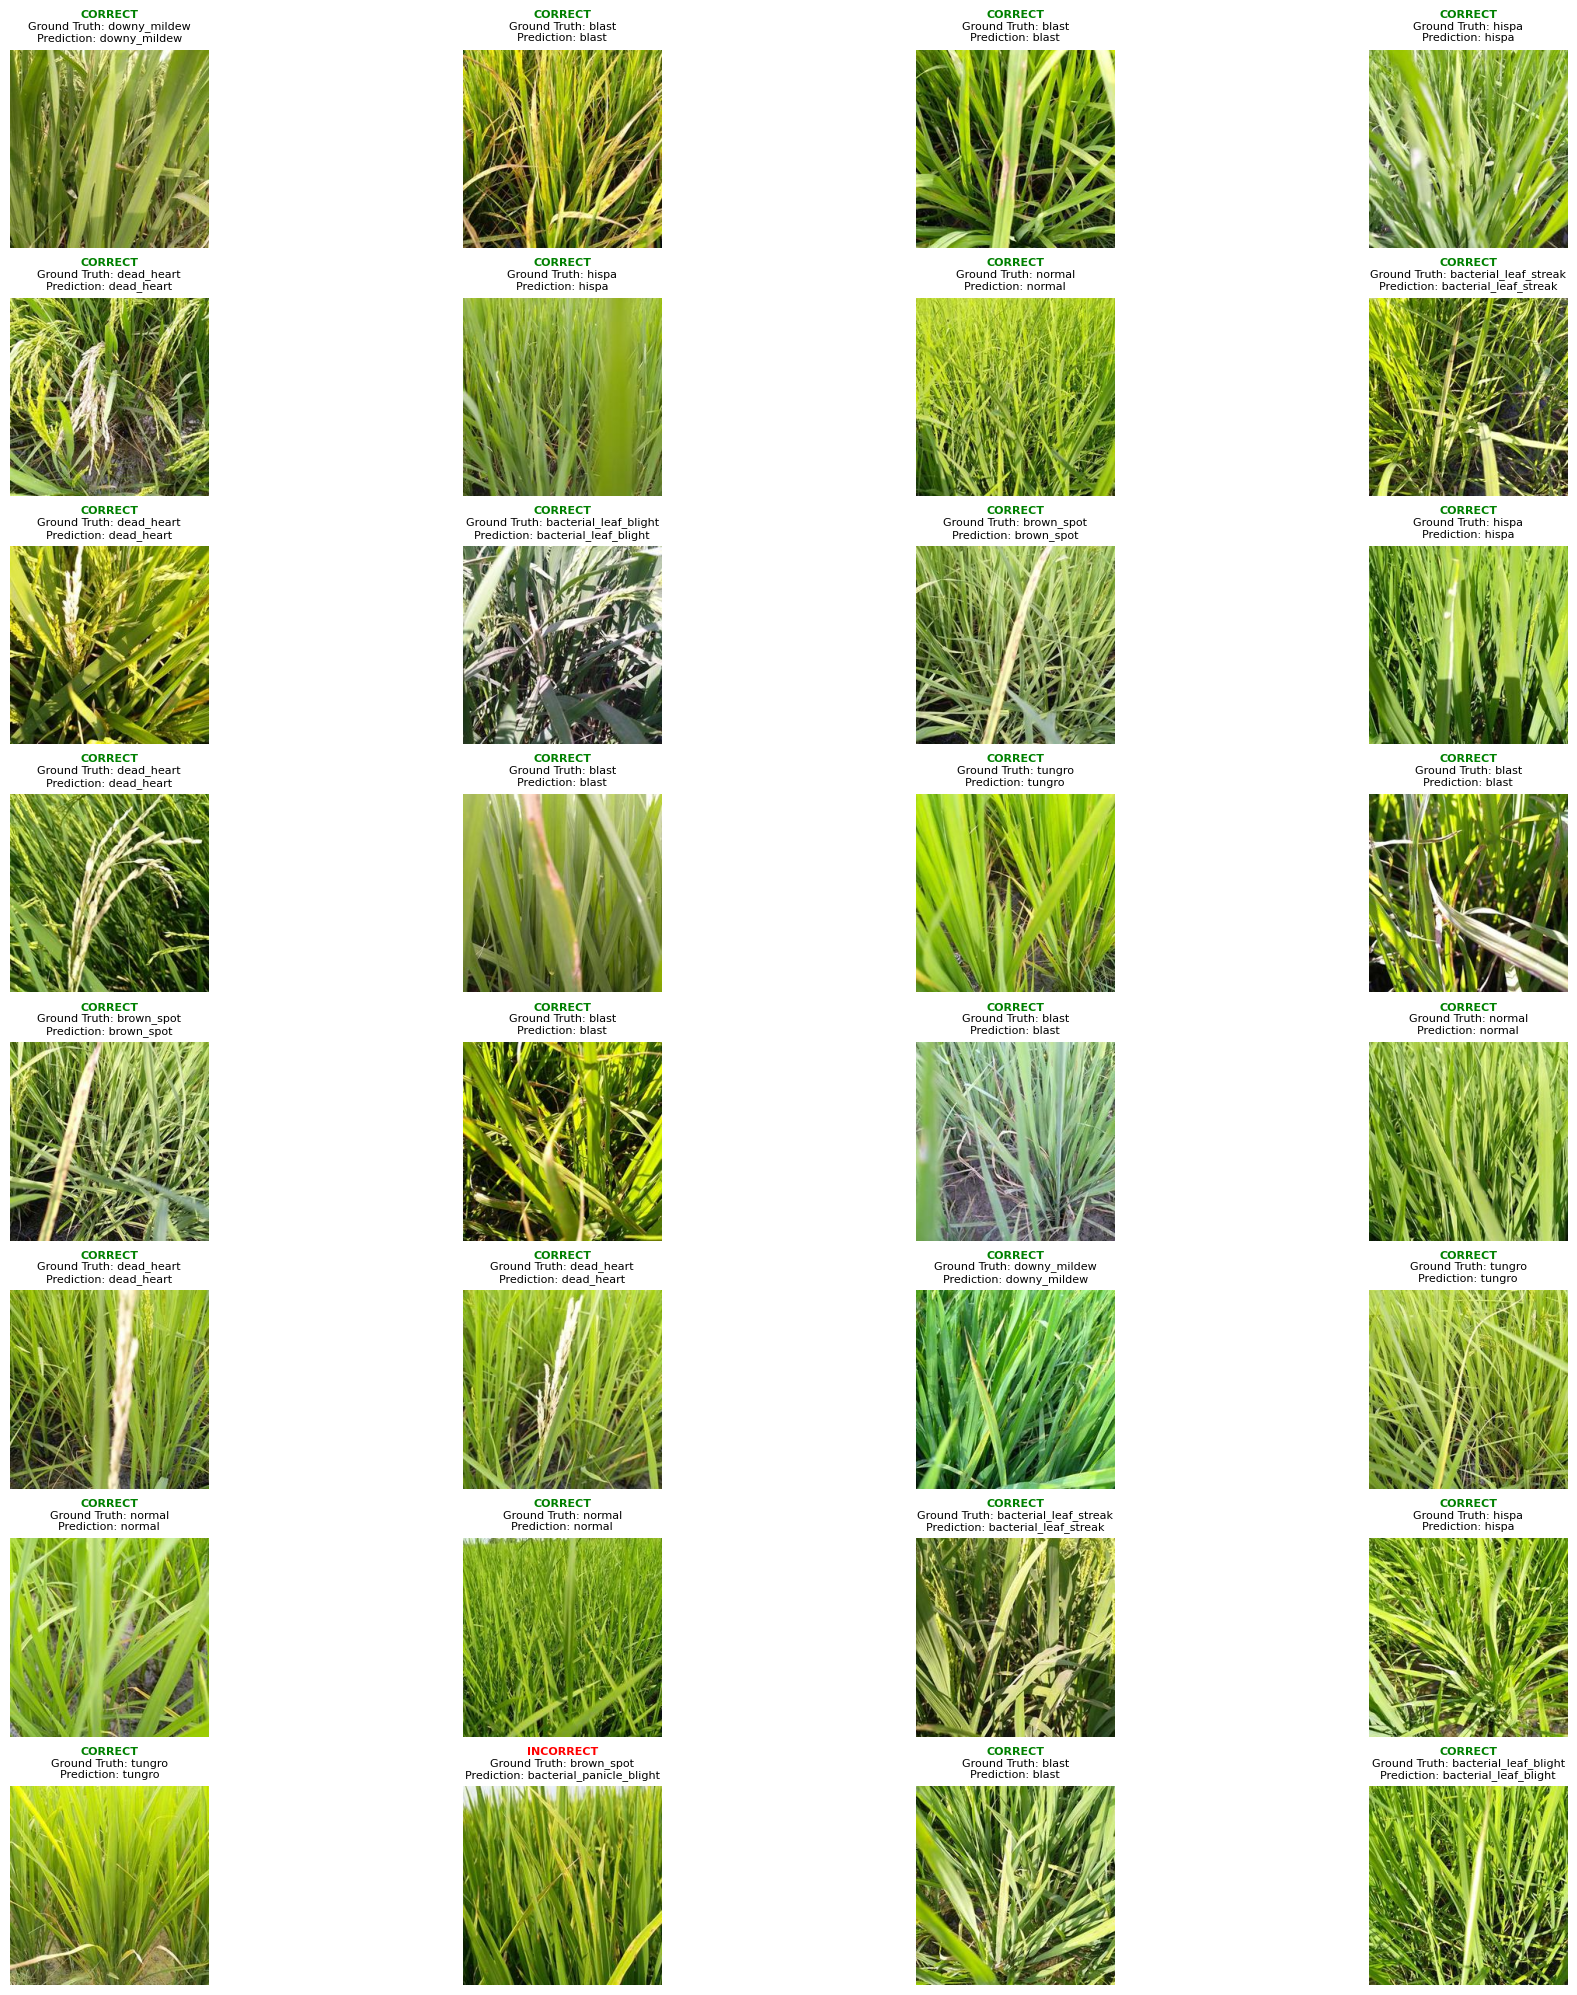

In [23]:
visualize_32predictions(model, test_generator)

In [24]:
# Evaluate on training set
train_loss, train_acc = model.evaluate(train_generator, steps=len(train_generator), verbose=1)
print(f"Train Accuracy: {train_acc:.4f}, Loss: {train_loss:.4f}")

# Evaluate on validation set
val_loss, val_acc = model.evaluate(val_generator, steps=len(val_generator), verbose=1)
print(f"Validation Accuracy: {val_acc:.4f}, Loss: {val_loss:.4f}")

353/353 ━━━━━━━━━━━━━━━━━━━━ 33s 92ms/step - categorical_accuracy: 0.9937 - loss: 0.0214
Train Accuracy: 0.9929, Loss: 0.0227
89/89 ━━━━━━━━━━━━━━━━━━━━ 6s 71ms/step - categorical_accuracy: 0.9660 - loss: 0.1412
Validation Accuracy: 0.9632, Loss: 0.1500


In [25]:
# Evaluate on testing set
test_loss, test_acc = model.evaluate(test_generator, steps=len(test_generator), verbose=1)
print(f"Test Accuracy: {test_acc:.4f}, Loss: {test_loss:.4f}")

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


2844/2844 ━━━━━━━━━━━━━━━━━━━━ 14s 5ms/step - categorical_accuracy: 0.9805 - loss: 0.0746
Test Accuracy: 0.9680, Loss: 0.1319


In [ ]:
# === CONFIG ===
TEST1_DIR = '/test_images/'
IMAGE_SIZE = (256, 256)
BATCH_SIZE = 1

# === Load test filenames ===
test1_filenames = os.listdir(TEST1_DIR)

# Create DataFrame for generator
test1_df = pd.DataFrame({'filename': test1_filenames})

# === Prepare Test Data Generator ===
test1_datagen = ImageDataGenerator(data_format="channels_last")

test1_generator = test1_datagen.flow_from_dataframe(
    test1_df,
    directory=TEST1_DIR,
    x_col='filename',
    y_col=None,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode=None,
    shuffle=False
)



# === Predict on Test Data ===
preds = model.predict(test1_generator, verbose=1)
predicted_class_indices = np.argmax(preds, axis=1)

# === Get Class Labels ===
class_names = [
    'bacterial_leaf_blight',
    'bacterial_leaf_streak',
    'bacterial_panicle_blight',
    'blast',
    'brown_spot',
    'dead_heart',
    'downy_mildew',
    'hispa',
    'normal',
    'tungro'
]

class_indices = {name: idx for idx, name in enumerate(class_names)}
labels = dict((v, k) for k, v in class_indices.items())

# Map predicted indices to class names
predicted_labels = [labels[k] for k in predicted_class_indices]

# === Create Submission File ===
submission = pd.DataFrame({
    'image_id': test1_df['filename'],
    'label': predicted_labels
})

# Save to CSV
submission.to_csv('submission.csv', index=False)
print("✅ submission.csv generated successfully!")

Found 3469 validated image filenames.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


3469/3469 ━━━━━━━━━━━━━━━━━━━━ 17s 5ms/step
✅ submission.csv generated successfully!


In [31]:
model.save("disease-cnn-true.keras", overwrite = True)

In [ ]:
# Load model later
model = models.load_model(path_model + ".keras")

2844/2844 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step


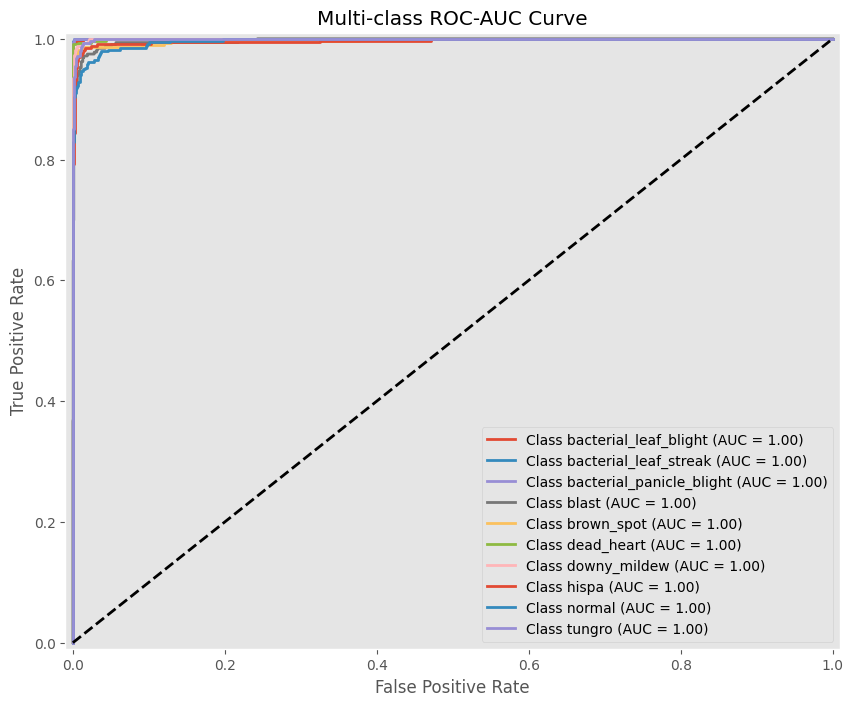

In [26]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Step 1: Predict probabilities
y_pred_probs = model.predict(test_generator, verbose=1)

# Step 2: Get true labels
y_true = test_generator.classes

# Step 3: Binarize true labels
n_classes = len(test_generator.class_indices)
y_true_bin = label_binarize(y_true, classes=list(range(n_classes)))

# Step 4: Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Step 5: Plot all ROC curves
plt.figure(figsize=(10, 8))

for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], lw=2,
             label=f'Class {list(test_generator.class_indices.keys())[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-class ROC-AUC Curve')
plt.legend(loc='lower right')
plt.grid()
plt.show()

In [27]:
from sklearn.metrics import classification_report

# Get predicted probabilities (logits since you used from_logits=True)
y_pred_report = model.predict(test_generator, verbose=1)

# Convert logits to predicted class indices
y_pred1 = np.argmax(y_pred_report, axis=1)

# True labels from the generator
y_true1 = test_generator.classes

# Label names
class_labels = list(test_generator.class_indices.keys())

# Classification report
report = classification_report(y_true1, y_pred1, target_names=class_labels, digits=4)
print(report)

2844/2844 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step
                          precision    recall  f1-score   support

   bacterial_leaf_blight     0.9883    0.9922    0.9903       256
   bacterial_leaf_streak     0.9876    1.0000    0.9937       238
bacterial_panicle_blight     0.9730    1.0000    0.9863       216
                   blast     0.9292    0.9557    0.9423       316
              brown_spot     0.9714    0.9714    0.9714       280
              dead_heart     0.9937    0.9875    0.9906       321
            downy_mildew     0.9806    0.9656    0.9731       262
                   hispa     0.9259    0.9760    0.9503       333
                  normal     0.9869    0.9012    0.9421       334
                  tungro     0.9615    0.9549    0.9582       288

                accuracy                         0.9680      2844
               macro avg     0.9698    0.9705    0.9698      2844
            weighted avg     0.9686    0.9680    0.9679      2844



2844/2844 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step


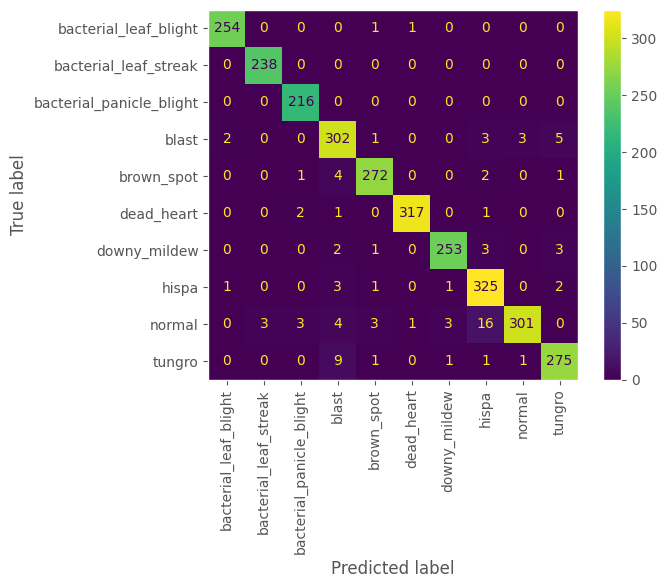

In [28]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Predict
y_pred2 = model.predict(test_generator, verbose=1)
y_true2 = test_generator.classes
y_pred_classes = y_pred2.argmax(axis=1)

# Plot confusion matrix
disp = ConfusionMatrixDisplay.from_predictions(
    y_true2,
    y_pred_classes,
    display_labels=test_generator.class_indices.keys(),
    xticks_rotation=90
)

# Remove gridlines
disp.ax_.grid(False)

plt.show()